In [26]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_curve, auc,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from medmnist import PathMNIST

import torchvision.models as models

import numpy as np

import warnings
warnings.filterwarnings("ignore")

### Load model

In [2]:
def load_model(model_path, device):
    model = torch.load(model_path, map_location=device)
    model.eval()
    return model

### Test model

In [3]:
def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metric
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Res
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return acc, precision, recall, f1, cm

### Plot ROC

In [4]:
def plot_roc_curve(model, test_loader, device, num_classes=9):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Binary label representation for AUC (one-vs-rest)
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))

    # Calculating AUC and ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calculating the average AUC
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    for i in range(num_classes):
        mean_tpr += np.interp(mean_fpr, fpr[i], tpr[i])

    mean_tpr /= num_classes

    plt.figure(figsize=(8, 8))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {np.mean(list(roc_auc.values())):.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Mean AUC)')
    plt.legend(loc='lower right')
    plt.show()

### Plot roc for every class

In [24]:
def plot_roc_curve_all_classes(model, test_loader, device, num_classes=9, label_dict=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))

    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(10, 10))

    colors = plt.cm.get_cmap("tab10", num_classes)
        
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        nm = class_labels[str(i)]
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f"{nm} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2, label="Random Guess")

    mean_auc = np.mean(list(roc_auc.values()))
    print(f"Średnia AUC dla wszystkich klas: {mean_auc:.2f}")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Multi-Class Classification")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

### Device Settings

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Test data preparation

In [7]:
transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [8]:
test_dataset = PathMNIST(
    split="test", size=64, transform=transform_val_test, download=True,
    target_transform=lambda x: torch.tensor(x, dtype=torch.long).squeeze()
)

Using downloaded and verified file: C:\Users\Kinga\.medmnist\pathmnist_64.npz


In [9]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Class labels

In [10]:
class_labels = test_dataset.info['label']
class_labels

{'0': 'adipose',
 '1': 'background',
 '2': 'debris',
 '3': 'lymphocytes',
 '4': 'mucus',
 '5': 'smooth muscle',
 '6': 'normal colon mucosa',
 '7': 'cancer-associated stroma',
 '8': 'colorectal adenocarcinoma epithelium'}

### Model Architectures

In [11]:
class AdvancedModel(nn.Module):
    def __init__(self, num_classes=9, input_shape=(3, 64, 64)):
        super(AdvancedModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Calculating the output dimension for the classifier
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).size(1)
            # print(f"Flattened size: {flattened_size}")  
            
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [12]:
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes=9, pretrained=True):
        super(TransferLearningModel, self).__init__()
        
        self.base_model = models.resnet18(pretrained=pretrained)

        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.base_model(x)

In [13]:
class TransferLearningModelResNet50(nn.Module):
    def __init__(self, num_classes=9, pretrained=True):
        super(TransferLearningModelResNet50, self).__init__()
        
        self.base_model = models.resnet50(pretrained=pretrained)
        
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.base_model(x)

In [14]:
class TransferLearningModelSqueezenet(nn.Module):
    def __init__(self, num_classes=9, pretrained=True):
        super(TransferLearningModelSqueezenet, self).__init__()

        # Wczytanie pretrenowanego SqueezeNet1_1
        self.base_model = models.squeezenet1_1(pretrained=pretrained)

        # Dostosowanie klasyfikatoraa
        self.base_model.classifier = nn.Sequential(
            nn.Conv2d(512, num_classes, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # Globalne uśrednianie
        )
        self.num_classes = num_classes

    def forward(self, x):
        return self.base_model(x)

In [15]:
class TransferLearningModelDenseNet(nn.Module):
    def __init__(self, num_classes=9, pretrained=True):
        super(TransferLearningModelDenseNet, self).__init__()

        self.base_model = models.densenet121(pretrained=pretrained)

        num_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

### Converting keys to numbers

In [16]:
class_labels = {int(k): v for k, v in class_labels.items()}

### Model Definition

In [27]:
model = TransferLearningModelSqueezenet(num_classes=9)
model.load_state_dict(torch.load("./ModelSqueezenet.pth", map_location=device, weights_only=True))
model.to(device)  
model.eval()  

TransferLearningModelSqueezenet(
  (base_model): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padd

### Number of classes in the dataset

In [19]:
num_classes = len(test_dataset.info["label"])
classes = [f"Class {i}" for i in range(num_classes)]

### Testing the model

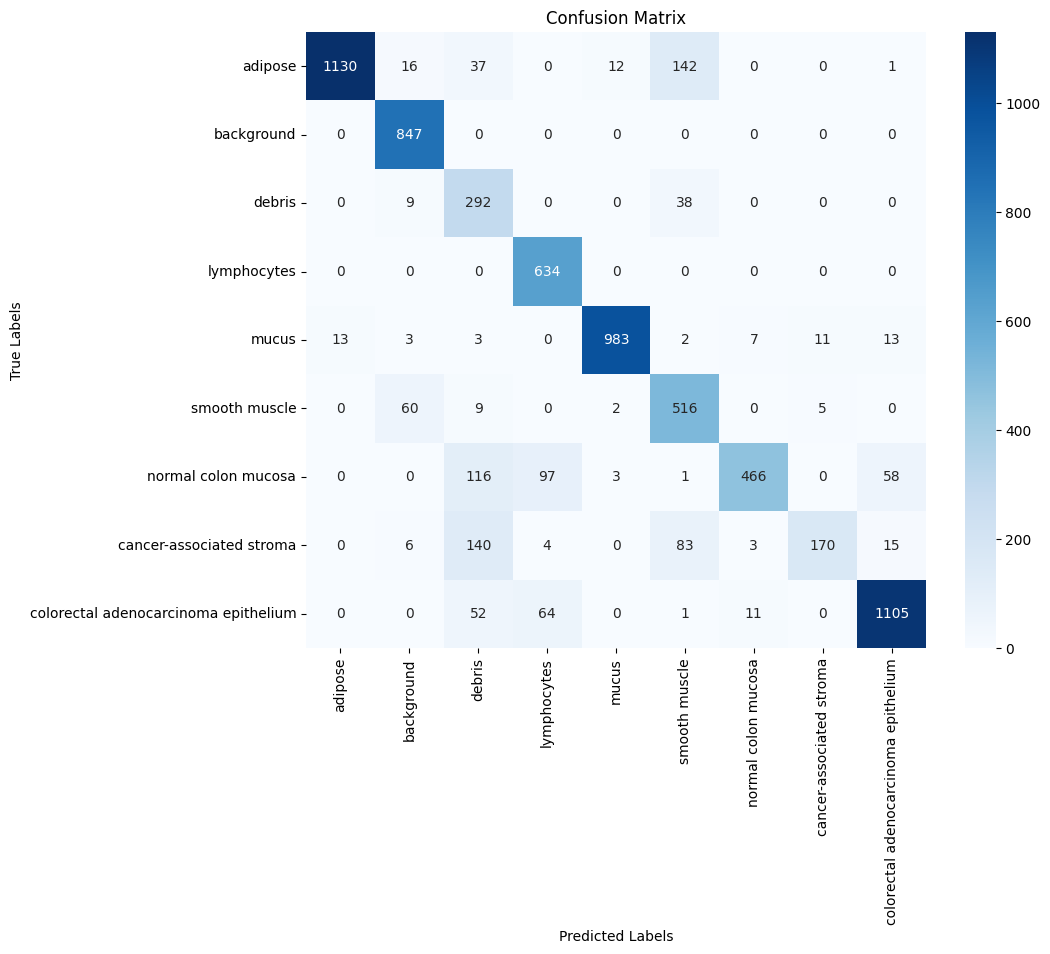

Accuracy: 0.8556
Precision: 0.8893
Recall: 0.8556
F1 Score: 0.8564


In [20]:
test_metrics = test_model(model, test_loader, device)

In [21]:
class_labels = test_dataset.info['label']

Średnia AUC dla wszystkich klas: 0.92


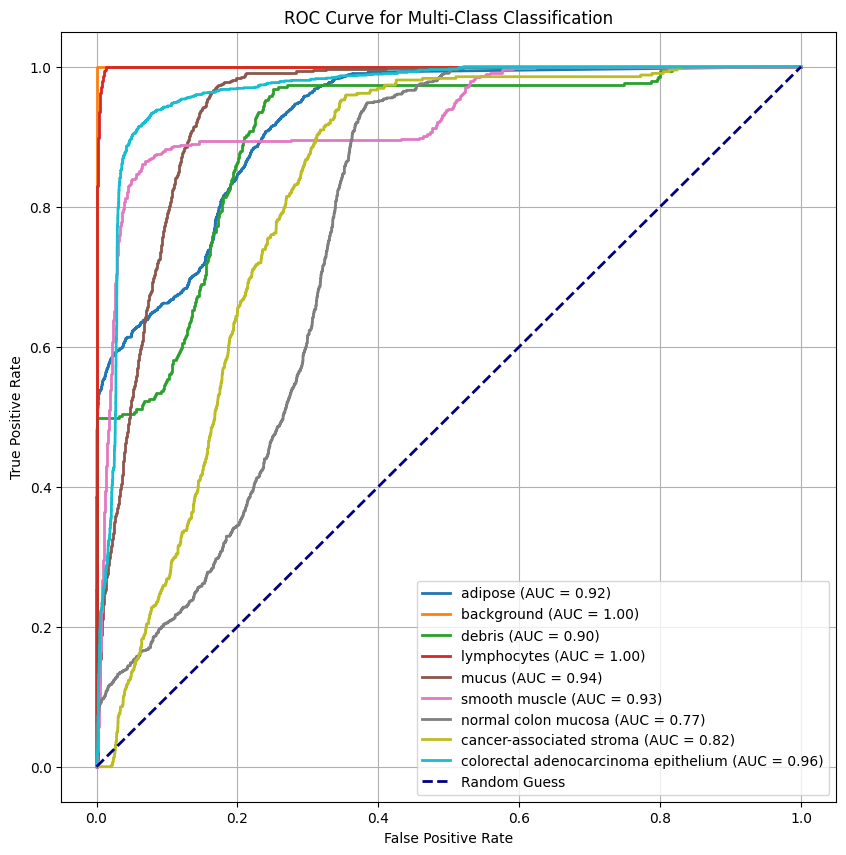

In [28]:
plot_roc_curve_all_classes(model, test_loader, device, num_classes=9, label_dict=class_labels)